<a href="https://colab.research.google.com/github/Chris-Congleton/MSc-Thesis/blob/main/Volkskrant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and loading data

In [1]:
import json, os
import pandas as pd
import nltk
import glob
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
nltk.download('punkt')
import seaborn as sns
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
path_to_json = "gdrive/MyDrive/CS/Thesis/volkskrant-nl"
json_files = ["gdrive/MyDrive/CS/Thesis/volkskrant-nl/"+pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(json_files[:5])

['gdrive/MyDrive/CS/Thesis/volkskrant-nl/volkskrant-nl-2002-01.json', 'gdrive/MyDrive/CS/Thesis/volkskrant-nl/volkskrant-nl-2002-02.json', 'gdrive/MyDrive/CS/Thesis/volkskrant-nl/volkskrant-nl-2002-03.json', 'gdrive/MyDrive/CS/Thesis/volkskrant-nl/volkskrant-nl-2002-04.json', 'gdrive/MyDrive/CS/Thesis/volkskrant-nl/volkskrant-nl-2002-05.json']


In [4]:
def readFiles(file_names):
  dfs = [] # an empty list to store the data frames
  for f in tqdm(file_names):
    data = pd.read_json(f) # read data frame from json file
    dfs.append(data) # append the data frame to the list

  df = pd.concat(dfs, ignore_index=True) # concatenate all the data frames in the list.
  return df

In [5]:
df = readFiles(json_files)
df.shape

100%|██████████| 214/214 [04:10<00:00,  1.17s/it]


(862852, 14)

In [6]:
df.tail(2)

,categories,cleaned,cleantext,keywords,leading-image,leading-image-caption-content,leading-image-caption-source,leading-image-copyright,og-description,og-image,og-title,timestamp,title,url
862850,Nieuws &amp; Achtergrond,2019-10-16T20:57:04.925000,De nieuwsredactie van de Volkskrant. Beeld Sim...,"[De Volkskrant, economie, business en financië...",https://images4.persgroep.net/rcs/zZXXTbiZRNbQ...,De nieuwsredactie van de Volkskrant.,Beeld Simon Lenskens,Beeld Simon Lenskens,De Volkskrant zoekt freelance-internetredacteu...,https://images4.persgroep.net/rcs/zZXXTbiZRNbQ...,De Volkskrant zoekt internetredacteuren,2019-10-10 07:50:00,De Volkskrant zoekt internetredacteuren,https://www.volkskrant.nl/nieuws-achtergrond/d...
862851,Economie,2019-10-16T22:25:15.752000,Aviko is het tweede grootste aardappelverwerke...,"[Colombia, economie, business en financiën, ec...",https://images0.persgroep.net/rcs/nxqS6pJvbjRy...,Aviko is het tweede grootste aardappelverwerke...,Beeld Hollandse Hoogte / John van Hamond,Beeld Hollandse Hoogte / John van Hamond,Brussel stapt naar de Wereldhandelsorganisatie...,https://images0.persgroep.net/rcs/nxqS6pJvbjRy...,EU naar Wereldhandelsorganisatie wegens Colomb...,2019-10-15 15:10:00,EU naar Wereldhandelsorganisatie wegens Colomb...,https://www.volkskrant.nl/economie/minister-ka...


# Exploratory Data Analysis

Text(0.5, 1.0, 'Total number of articles')

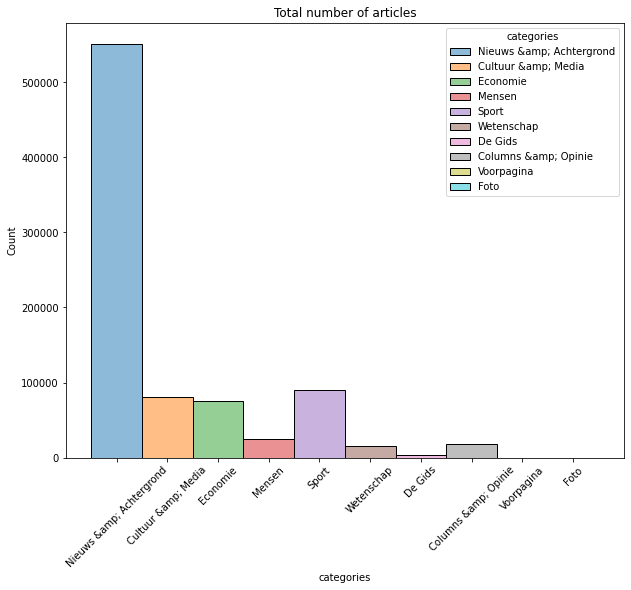

In [7]:
f, axs = plt.subplots(1,figsize=(10, 8))
sns.histplot(data=df, x="categories", hue="categories", ax=axs)
axs.tick_params(axis='x', rotation=45)
axs.set_title("Total number of articles")

Text(0.5, 1.0, 'Number of articles')

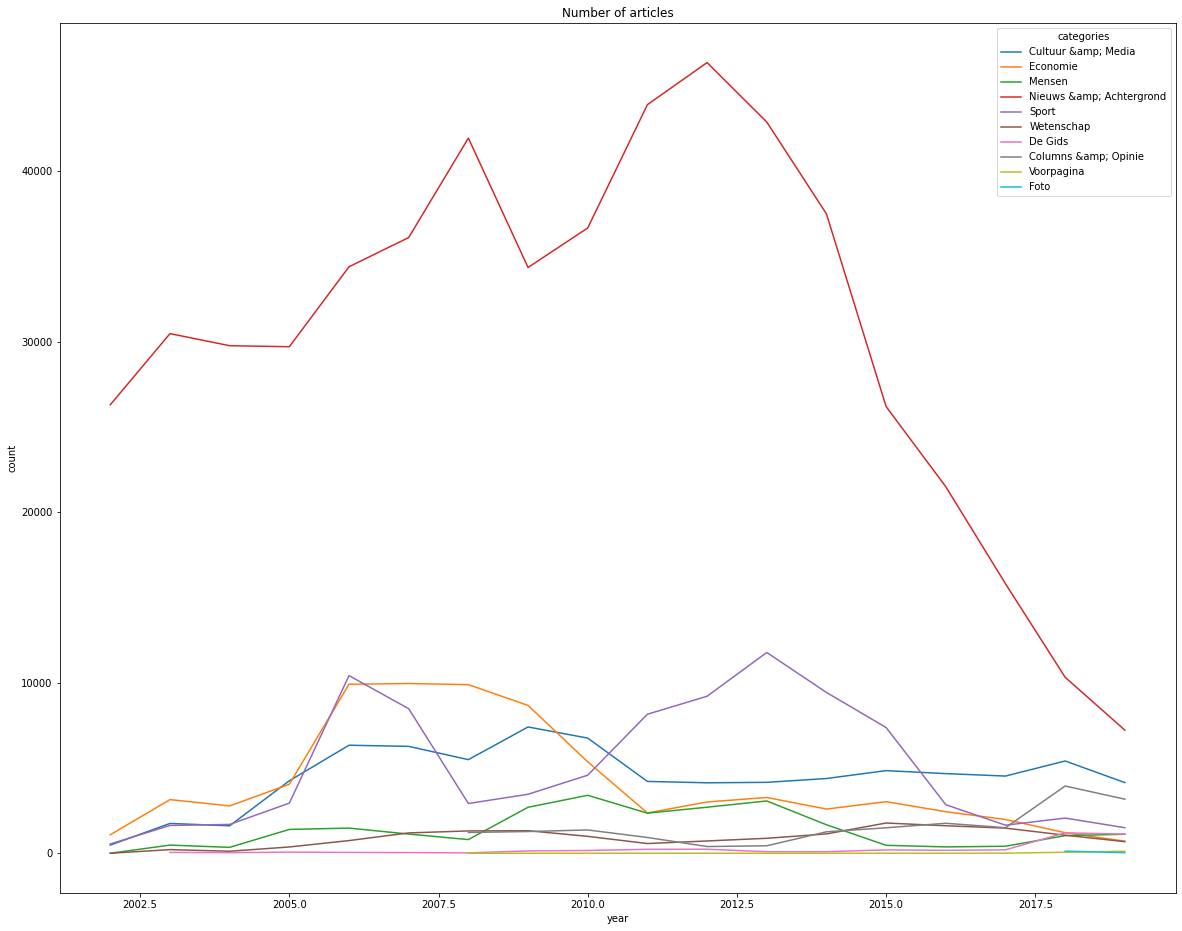

In [101]:
df_year = df.copy(deep=True)
df_year["year"] = df_year.timestamp.dt.year
time_df = pd.DataFrame({'count':df_year.groupby(["year","categories"]).size()}).reset_index()
f, axs = plt.subplots(1,figsize=(20, 16))
sns.lineplot(data=time_df, x='year',y='count',hue='categories',ci=None, palette=["C0", "C1", "C2", "C3", "C4",
                                                                                 "C5", "C6", "C7", "C8", "C9"])
axs.set_title("Number of articles")

The counts of articles collected per year per category vary quite a bit with for example ~45.000 "News & Background" articles in 2012 and ~10.000 in 2019. These should be normalised when counting party or politician mentions for example. 

Text(0.5, 1.0, 'Total length of articles')

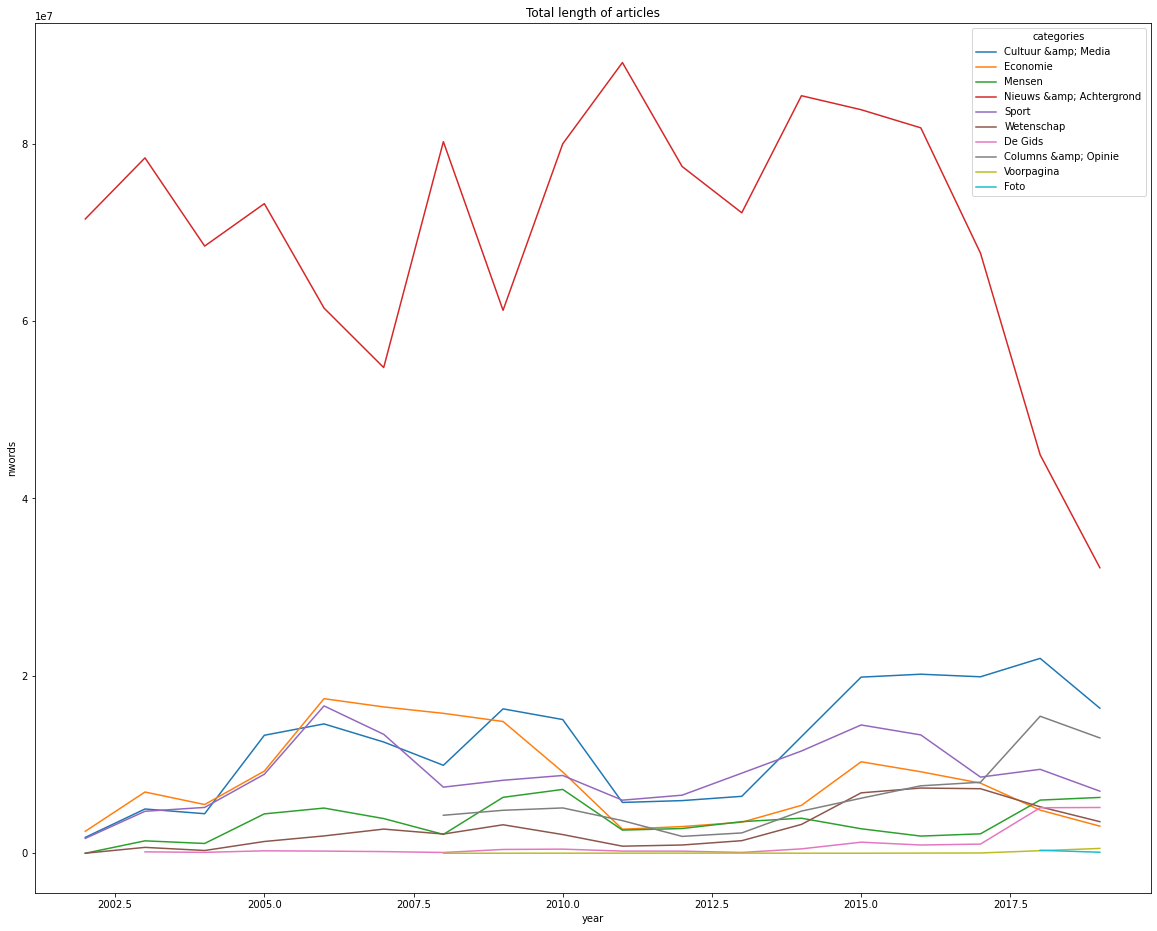

In [100]:
df_nwords = df.copy(deep=True)
df_nwords["year"] = df_nwords.timestamp.dt.year
df_nwords["nwords"] = df_nwords.cleantext.str.len()
df_nwords = pd.DataFrame(df_nwords.groupby(["year","categories"])["nwords"].agg("sum")).reset_index()

f, axs = plt.subplots(1,figsize=(20, 16))
sns.lineplot(data=df_nwords, x='year',y='nwords',hue='categories',ci=None, palette=["C0", "C1", "C2", "C3", "C4",
                                                                                 "C5", "C6", "C7", "C8", "C9"])
axs.set_title("Total length of articles")

The total amount of words collected is highest for news and background articles. This graph shows a different balance in data.

# Frequentie politieke partijen

In [90]:
# Lijst partijen tweede kamer per jaar: 
# Bron: https://www.parlement.com/id/vk9scmucgjhj/aantal_deelnemende_partijen_tweede

tk_2002 = ["CDA", "LPF", "VVD", "PvdA", "GL", "SP", "D66", "CU", "SGP", "LN"]
tk_2003 = ["CDA", "LPF", "VVD", "PvdA", "GnL", "SP", "D66", "CU", "SGP"]
tk_2006 = ["CDA", "VVD", "PvdA", "GL", "SP", "D66", "CU", "SGP", "PVV", "PvdD"]
tk_2010 = ["CDA", "VVD", "PvdA", "GL", "SP", "D66", "CU", "SGP", "PVV", "PvdD"]
tk_2012 = ["CDA", "VVD", "PvdA", "GL", "SP", "D66", "CU", "SGP", "PVV", "PvdD", "50PLUS"]
tk_2017 = ["CDA", "VVD", "PvdA", "GL", "SP", "D66", "CU", "SGP", "PVV", "PvdD", "50PLUS", "DENK", "FVD"]
tk_2021 = ["CDA", "VVD", "PvdA", "GL", "SP", "D66", "CU", "SGP", "PVV", "PvdD", "50PLUS", "DENK",
           "FVD", "BIJ1", "BBB", "JA21", "VOLT"]

# Convert to one unique list
tk = [tk_2002, tk_2003,tk_2006,tk_2010,tk_2012,tk_2017,tk_2021]
tk = [item for sublist in tk for item in sublist]
partijen = list(set(tk))
print(partijen)

['LPF', 'VOLT', 'PvdA', 'GL', 'DENK', 'PVV', 'CDA', 'PvdD', 'SP', 'FVD', 'SGP', '50PLUS', 'BBB', 'JA21', 'BIJ1', 'GnL', 'VVD', 'CU', 'LN', 'D66']


In [91]:
df_partij = df.copy(deep=True)
df_partij["year"] = df_partij.timestamp.dt.year

for p in partijen:
  df_partij[p] = df_partij.cleantext.str.count(p)

df_party_counts = pd.DataFrame()

for p in partijen:
  df_party_counts[p] = df_partij.groupby(["year"])[p].agg("sum")

df_party_counts = df_party_counts.reset_index()
df_mentions = df_party_counts.melt('year')

In [96]:
df_mentions = df_mentions.rename(columns={'year':'Year','variable':'Party','value':'Frequency'})

# Drop rows where frequency is <1000
df_mentions = df_mentions[df_mentions.Frequency > 1000]
print(df_mentions.head())

    Year Party  Frequency
0   2002   LPF       3630
1   2003   LPF       1426
36  2002  PvdA       3390
37  2003  PvdA       4429
38  2004  PvdA       2500


Text(0.5, 1.0, 'Party mentions in Volkskrant')

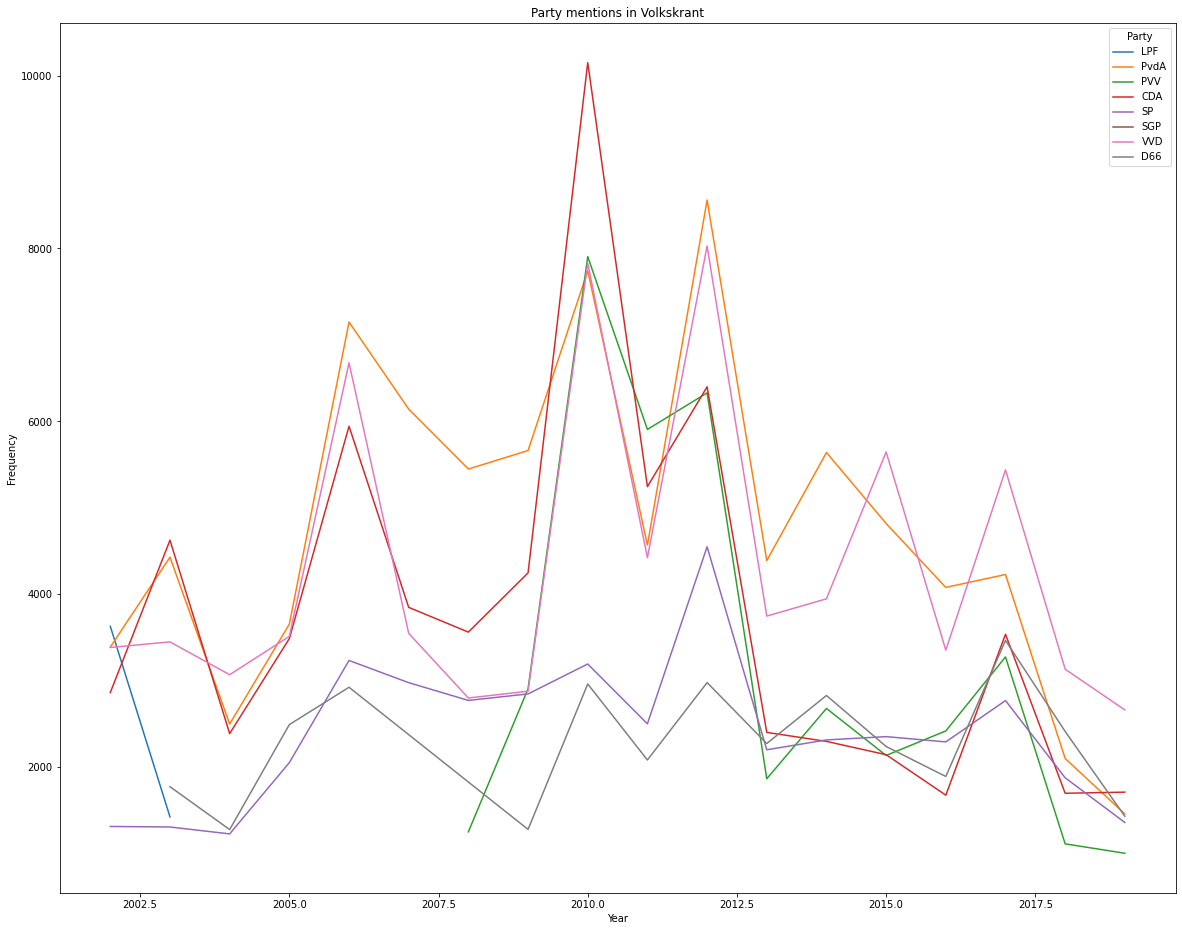

In [99]:
f, axs = plt.subplots(1,figsize=(20, 16))
sns.lineplot(data=df_mentions, x='Year',y='Frequency', hue='Party')
axs.set_title("Party mentions in Volkskrant")